In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/빅데이터팀플

/content/drive/MyDrive/빅데이터팀플


# 머신러닝

In [ ]:
# 라이브러리 불러오기
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score,classification_report,confusion_matrix

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Flatten, Input, concatenate, Conv1D, GlobalMaxPooling1D, MaxPooling1D

In [ ]:
# 문자 전처리 함수

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [ ]:
# 데이터 불러오기
df_train = pd.read_csv('./datasets/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('./datasets/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('./datasets/test.txt', names=['Text', 'Emotion'], sep=';')

In [ ]:
# 데이터 확인하기
display(df_train)
display(df_test)
display(df_val)

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


,Text,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


,Text,Emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


In [ ]:
# train 데이터, val 데이터 병합
train=[df_train,df_val]
df=pd.concat(train)
df=df.reset_index()

# index 열 삭제
df=df.drop(columns='index')
df

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
17995,im having ssa examination tomorrow in the morn...,sadness
17996,i constantly worry about their fight against n...,joy
17997,i feel its important to share this info for th...,joy
17998,i truly feel that if you are passionate enough...,joy


In [ ]:
# 레이블 인코딩
from sklearn.preprocessing import LabelEncoder

labelencoder=LabelEncoder()
df['label_enc']=labelencoder.fit_transform(df['Emotion'])
df_test['label_enc']=labelencoder.fit_transform(df_test['Emotion'])

In [ ]:
# 중복된 데이터 제거
data=df[['Emotion', 'label_enc']].drop_duplicates(keep='first')
data

,Emotion,label_enc
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


In [ ]:
def relabel(a):
  if a==4:
    em='sadness'
  elif a==0:
    em='anger'
  elif a==3:
    em='love'
  elif a==5:
    em='surprise'
  elif a==1:
    em='fear'
  else:
    em='joy'
  
  return em

In [ ]:
df_test[['Emotion','label_enc']].drop_duplicates(keep='first')

,Emotion,label_enc
0,sadness,4
3,joy,2
5,fear,1
6,anger,0
14,love,3
65,surprise,5


In [ ]:
# TF-IDF 벡터화
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, stop_words='english')

features_train = tfidf.fit_transform(df.Text).toarray()
features_test = tfidf.transform(df_test.Text).toarray()

features_train_name = tfidf.get_feature_names()

labels = df.label_enc

print("추출이후 특징의 수 : "+str(features_train.shape[1]))

추출이후 특징의 수 : 3398


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
feature_train_df = pd.DataFrame(data=features_train, columns=features_train_name)
feature_train_df

,abandoned,abilities,ability,abit,able,absolute,absolutely,abuse,abused,accept,...,youd,youll,young,younger,youre,youth,youtube,youve,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
models = [
    RandomForestClassifier(),
    LinearSVC()
]

# 5개의 교차검증
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features_train, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.881944
1,RandomForestClassifier,1,0.887778
2,RandomForestClassifier,2,0.870278
3,RandomForestClassifier,3,0.885278
4,RandomForestClassifier,4,0.890833
5,LinearSVC,0,0.897500
6,LinearSVC,1,0.889167
7,LinearSVC,2,0.882222
8,LinearSVC,3,0.890278
9,LinearSVC,4,0.895000


In [ ]:
# 높은 정확도를 가진 모델들 추출
model_acc=cv_df['accuracy'].groupby(cv_df['model_name']).max()
model_acc

model_name
LinearSVC                 0.897500
RandomForestClassifier    0.890833
Name: accuracy, dtype: float64

### LinearSVC

In [ ]:
model = LinearSVC()
model.fit(features_train, labels)
y_pred = model.predict(features_test)

In [ ]:
pred_cat = []
for i in y_pred:
  cat = relabel(i)
  pred_cat.append(cat)
pred_cat = np.array(pred_cat)

In [ ]:
print(classification_report(df_test.Emotion, pred_cat))

              precision    recall  f1-score   support

       anger       0.87      0.88      0.88       275
        fear       0.88      0.86      0.87       224
         joy       0.90      0.92      0.91       695
        love       0.75      0.75      0.75       159
     sadness       0.93      0.92      0.92       581
    surprise       0.74      0.68      0.71        66

    accuracy                           0.89      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.89      0.89      0.89      2000



In [ ]:
def predict_emotion(text):
    x = tfidf.transform([text]).toarray()
    pred = relabel(model.predict(x))
    return pred

In [ ]:
text = "i am very happy"
predict_emotion(text)

'joy'

### 랜덤포레스트

In [ ]:
model = RandomForestClassifier()
model.fit(features_train, labels)
y_pred = model.predict(features_test)

In [ ]:
pred_cat = []
for i in y_pred:
  cat = relabel(i)
  pred_cat.append(cat)
pred_cat = np.array(pred_cat)

In [ ]:
print(classification_report(df_test.Emotion, pred_cat))

              precision    recall  f1-score   support

       anger       0.90      0.90      0.90       275
        fear       0.83      0.90      0.86       224
         joy       0.90      0.91      0.90       695
        love       0.76      0.72      0.74       159
     sadness       0.94      0.92      0.93       581
    surprise       0.72      0.65      0.68        66

    accuracy                           0.89      2000
   macro avg       0.84      0.83      0.84      2000
weighted avg       0.88      0.89      0.88      2000



In [ ]:
def predict_emotion(text):
    x = tfidf.transform([text]).toarray()
    pred = relabel(model.predict(x))
    return pred

In [ ]:
text = "i feel a bit stressed even though all the things i have going on are fun"
predict_emotion(text)

'sadness'

# 딥러닝

In [ ]:
import pandas as pd

test_data = pd.read_csv("./datasets/test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
train_data = pd.read_csv("./datasets/train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("./datasets/val.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")

In [ ]:
print("Train : ", train_data.shape)
print("Test : ", test_data.shape)
print("Validation : ", validation_data.shape)

Train :  (16000, 2)
Test :  (2000, 2)
Validation :  (2000, 2)


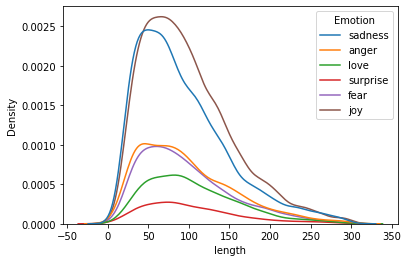

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 감정 길이 빈도 확인
train_data["length"] = [len(i) for i in train_data["Comment"]]
sns.kdeplot(x=train_data["length"], hue=train_data["Emotion"])

In [ ]:
# 데이터 전처리
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_data["Emotion"] = lb.fit_transform(train_data["Emotion"])
test_data["Emotion"] = lb.fit_transform(test_data["Emotion"])
validation_data["Emotion"] = lb.fit_transform(validation_data["Emotion"])

display(train_data.head())
display(test_data.head())
display(validation_data.head())

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


,Comment,Emotion
0,im feeling rather rotten so im not very ambiti...,4
1,im updating my blog because i feel shitty,4
2,i never make her separate from me because i do...,4
3,i left with my bouquet of red and yellow tulip...,2
4,i was feeling a little vain when i did this one,4


,Comment,Emotion
0,im feeling quite sad and sorry for myself but ...,4
1,i feel like i am still looking at a blank canv...,4
2,i feel like a faithful servant,3
3,i am just feeling cranky and blue,0
4,i can have for a treat or if i am feeling festive,2


In [ ]:
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [ ]:
vocab_size = 10000
train_data["length"].max()

300

In [ ]:
train_data["length"].min()

7

In [ ]:
len_sentence = 150

In [ ]:
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [ ]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 텍스트 전처리
def text_prepare(data, column):
    print(data.shape)
    stemmer = PorterStemmer()
    corpus = []
    
    for text in data[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        
        text = text.lower()
        text = text.split()
        
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    embeddec_doc = pad_sequences(sequences=one_hot_word,
                              maxlen=len_sentence,
                              padding="pre")
    print(data.shape)
    return embeddec_doc

In [ ]:
# comment 데이터 준비
x_train=text_prepare(train_data, "Comment")
x_validate=text_prepare(validation_data, "Comment")
x_test=text_prepare(test_data, "Comment")

(16000, 3)
(16000, 3)
(2000, 2)
(2000, 2)
(2000, 2)
(2000, 2)


In [ ]:
# 형태 파악
x_train.shape

(16000, 150)

In [ ]:
# emotion 데이터 준비
y_train=train_data["Emotion"]
y_validate=validation_data["Emotion"]
y_test=test_data["Emotion"]

In [ ]:
# emotion train data one-hot 인코딩 실시
import numpy as np
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_train = np.array(y_train)
y_train = enc.fit_transform(y_train.reshape(-1,1)).toarray()

In [ ]:
# emotion test data one-hot 인코딩 실시
y_test = np.array(y_test)
y_validate = np.array(y_validate)

y_test = enc.fit_transform(y_test.reshape(-1,1)).toarray()
y_validate = enc.fit_transform(y_validate.reshape(-1,1)).toarray()

In [ ]:
# Deep Learing 라이브러리 불러오기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# 모델 생성
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=150, input_length=len_sentence))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(6, activation="softmax"))

In [ ]:
model.compile(optimizer="Adam", loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5) # 과적합 방지를 위해 조기종료
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True) # 조기종료한 학습 모델 저장

In [ ]:
y_train.shape

(16000, 6)

In [ ]:
# 모델 학습
hist = model.fit(x_train, y_train, epochs = 25, batch_size = 64, validation_data=(x_validate, y_validate),verbose = 1, callbacks= [es, mc])

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 1.5485 - accuracy: 0.3828
Epoch 1: val_accuracy improved from -inf to 0.57100, saving model to ./model.h5
250/250 [==============================] - 106s 413ms/step - loss: 1.5485 - accuracy: 0.3828 - val_loss: 1.1909 - val_accuracy: 0.5710
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.7606
Epoch 2: val_accuracy improved from 0.57100 to 0.82650, saving model to ./model.h5
250/250 [==============================] - 103s 413ms/step - loss: 0.7407 - accuracy: 0.7606 - val_loss: 0.5308 - val_accuracy: 0.8265
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 0.3579 - accuracy: 0.8821
Epoch 3: val_accuracy improved from 0.82650 to 0.86000, saving model to ./model.h5
250/250 [==============================] - 103s 413ms/step - loss: 0.3579 - accuracy: 0.8821 - val_loss: 0.4301 - val_accuracy: 0.8600
Epoch 4/25
250/250 [==============================] - ETA: 0s

In [ ]:
# 테스트 정확도를 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(x_test, y_test)[1]))

63/63 [==============================] - 6s 90ms/step - loss: 0.4818 - accuracy: 0.8675

 Test Accuracy: 0.8675


# 워드클라우드

In [ ]:
# 데이터 불러오기
df_train = pd.read_csv('./datasets/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('./datasets/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('./datasets/test.txt', names=['Text', 'Emotion'], sep=';')

In [ ]:
#워드 클라우드
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    plt.axis("off");

In [ ]:
# Emotion
emotions_list = df_train['Emotion'].unique()
emotions_list

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

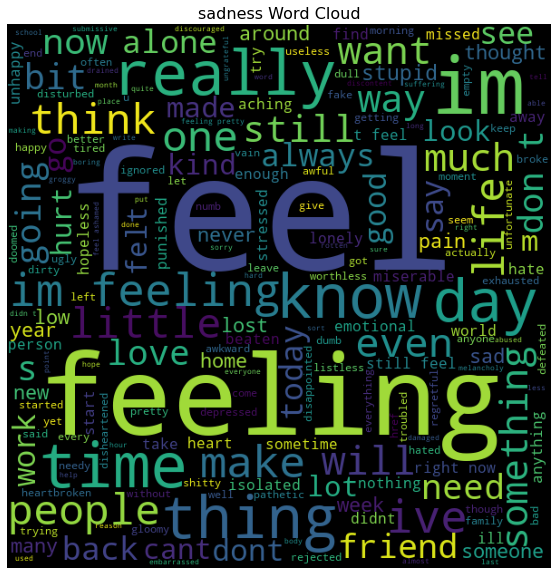

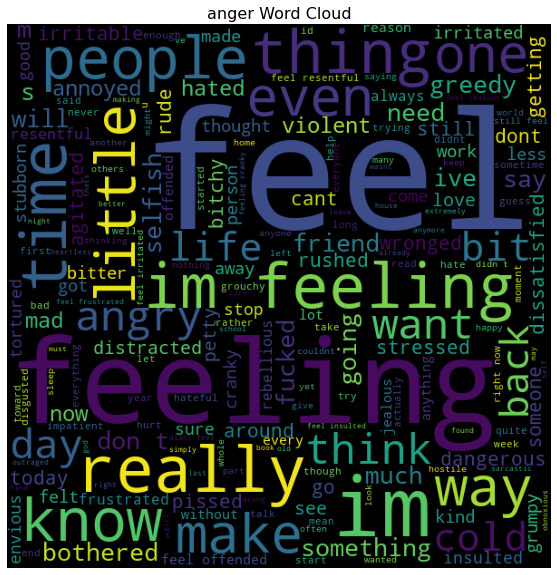

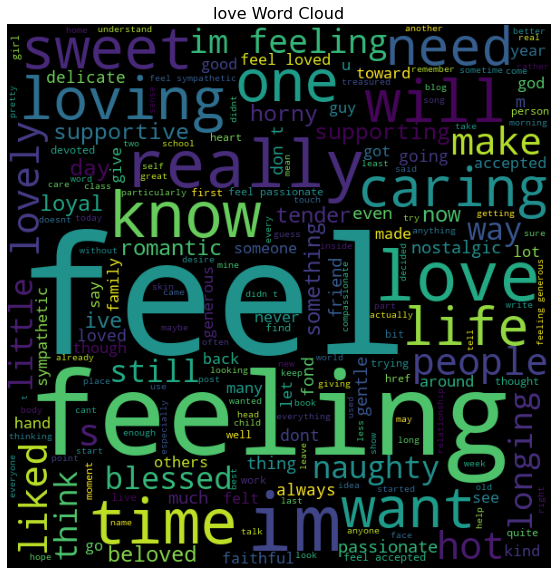

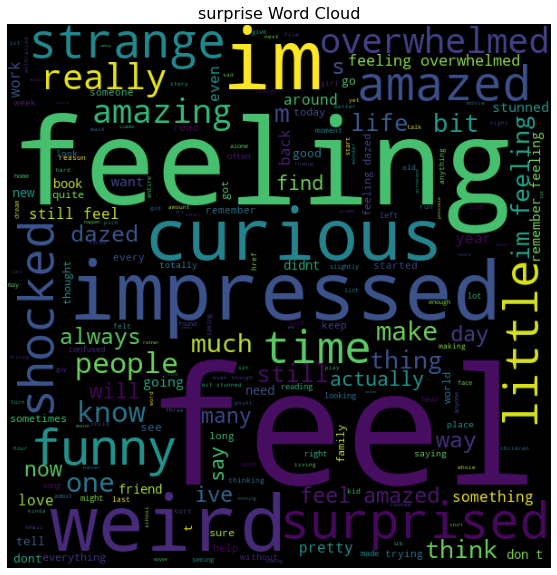

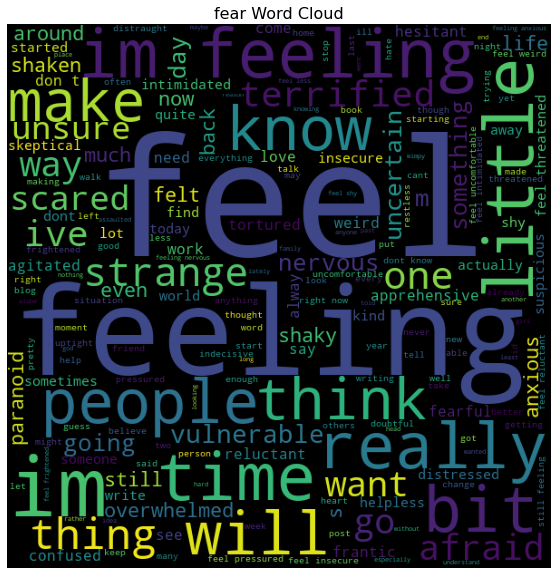

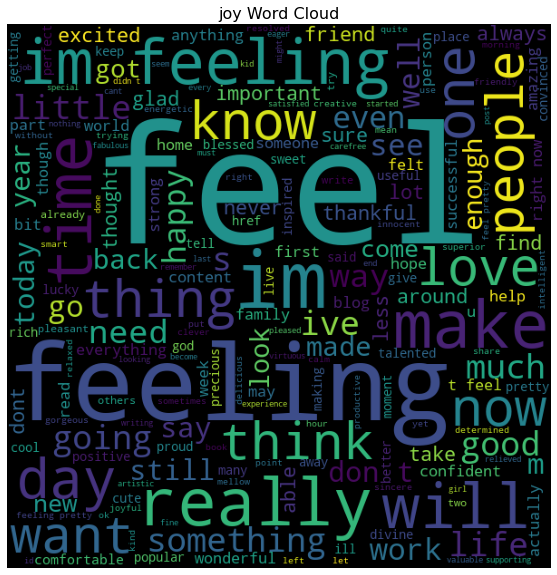

In [ ]:
from wordcloud import WordCloud

for emotion in emotions_list:
    text = ' '.join([sentence for sentence in df_train.loc[df_train['Emotion'] == emotion,'Text']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

In [ ]:
# 워드클라우드 이미지
from PIL import Image

anger_mask = np.array(Image.open('./datasets/mask/anger1.png'))
sad_mask = np.array(Image.open('./datasets/mask/sadness.png'))
love_mask = np.array(Image.open('./datasets/mask/love1.png'))
surp_mask = np.array(Image.open('./datasets/mask/surprise.png'))
fear_mask = np.array(Image.open('./datasets/mask/fear1.png'))
joy_mask = np.array(Image.open('./datasets/mask/joy1.png'))

In [ ]:
# Emotion 분리 'sadness', 'anger', 'love', 'surprise', 'fear', 'joy'
word_sad = df_train[df_train['Emotion'] == 'sadness']
word_anger = df_train[df_train['Emotion'] == 'anger']
word_love = df_train[df_train['Emotion'] == 'love']
word_surp = df_train[df_train['Emotion'] == 'surprise']
word_fear = df_train[df_train['Emotion'] == 'fear']
word_joy = df_train[df_train['Emotion'] == 'joy']

In [ ]:
#텍스트 추출
sad = word_sad['Text']
anger = word_anger['Text']
love = word_love['Text']
surp = word_surp['Text']
fear = word_fear['Text']
joy = word_joy['Text']

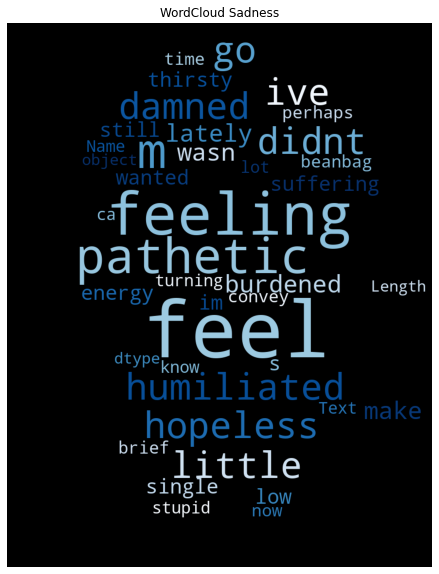

In [ ]:
# Sadness
wc_sad = WordCloud(
    width = 600,
    height = 600,
    mask = sad_mask,
    prefer_horizontal = True,
    colormap = 'Blues'
)

wc_sad.generate(str(sad))

plt.figure(figsize=(10,10))
plt.axis("off")
plt.title('WordCloud Sadness')
plt.imshow(wc_sad)
plt.show()

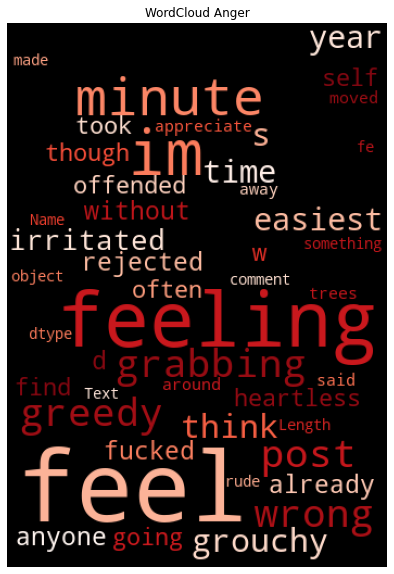

In [ ]:
# Anger
wc_anger = WordCloud(
    width = 600,
    height = 600,
    mask = anger_mask,
    prefer_horizontal = True,
    colormap = 'Reds'
)

wc_anger.generate(str(anger))

plt.figure(figsize=(10,10))
plt.axis("off")
plt.title('WordCloud Anger')
plt.imshow(wc_anger)
plt.show()

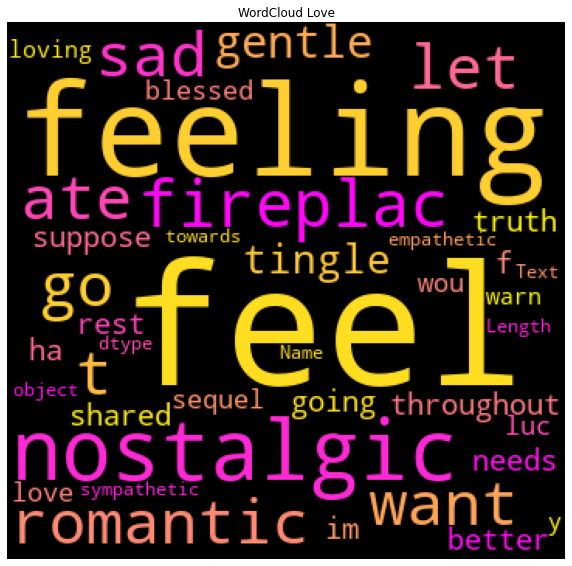

In [ ]:
# Love
wc_love = WordCloud(
    width = 600,
    height = 600,
    mask = love_mask,
    prefer_horizontal = True,
    colormap = 'spring'
)

wc_love.generate(str(love))

plt.figure(figsize=(10,10))
plt.axis("off")
plt.title('WordCloud Love')
plt.imshow(wc_love)
plt.show()

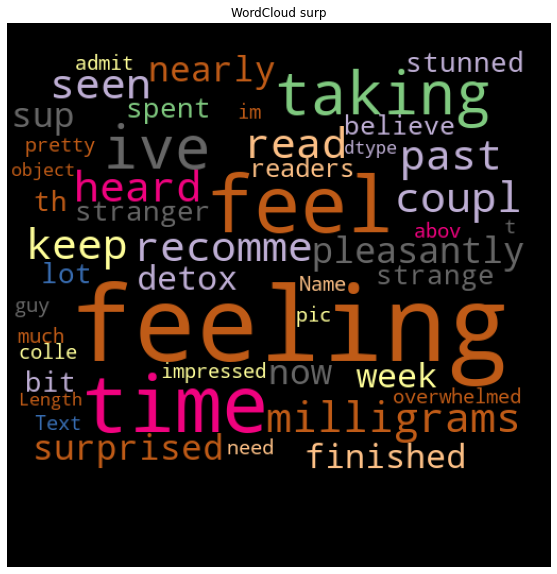

In [ ]:
# Surprise
wc_sup = WordCloud(
    width = 600,
    height = 600,
    mask = surp_mask,
    prefer_horizontal = True,
    colormap = 'Accent'
)

wc_sup.generate(str(surp))

plt.figure(figsize=(10,10))
plt.axis("off")
plt.title('WordCloud surp')
plt.imshow(wc_sup)
plt.show()

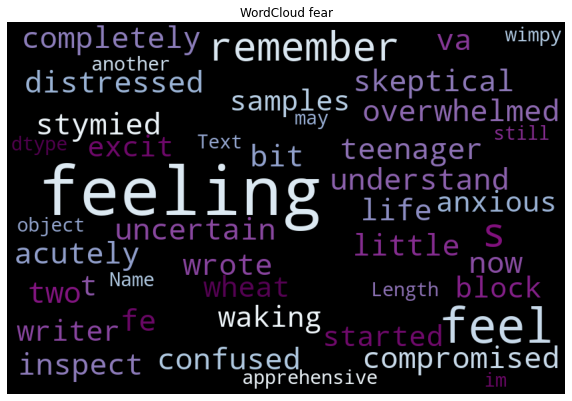

In [ ]:
# Fear
wc_fear = WordCloud(
    width = 600,
    height = 800,
    mask = fear_mask,
    prefer_horizontal = True,
    colormap = 'BuPu',
    max_words =300
)

wc_fear.generate(str(fear))

plt.figure(figsize=(10,10))
plt.axis("off")
plt.title('WordCloud fear')
plt.imshow(wc_fear)
plt.show()

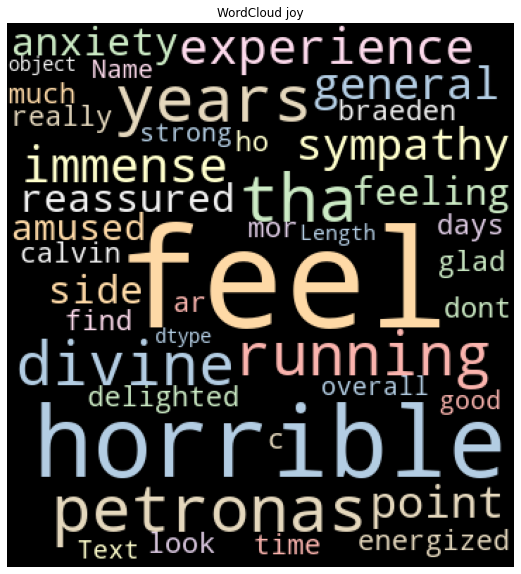

In [ ]:
# Joy
wc_joy = WordCloud(
    width = 600,
    height = 800,
    mask = joy_mask,
    prefer_horizontal = True,
    colormap = 'Pastel1',
    max_words =300
)

wc_joy.generate(str(joy))

plt.figure(figsize=(10,10))
plt.axis("off")
plt.title('WordCloud joy')
plt.imshow(wc_joy)
plt.show()